In [11]:
import sys
import os


ROOT = os.getcwd()
sys.path.append(os.path.dirname(os.path.dirname(ROOT)))

import numpy as np
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from DBSCAN.utils import Plot
from sklearn import datasets

In [12]:
def euclidean_distance(x1, x2):
    """ Calculates the l2 distance between two vectors """
    distance = 0
    # Squared distance between each coordinate
    for i in range(len(x1)):
        distance += pow((x1[i] - x2[i]), 2)
    return math.sqrt(distance)

class DBSCAN:

    def __init__(self, eps=1, min_samples=5):
        self.eps = eps
        self.min_samples = min_samples

    def _get_neighbors(self, sample_i):

        neighbors = []
        idxs = np.arange(len(self.X))
        for i, _sample in enumerate(self.X[idxs != sample_i]):
            distance = euclidean_distance(self.X[sample_i], _sample)
            if distance < self.eps:
                neighbors.append(i)
        return np.array(neighbors)

    def _expand_cluster(self, sample_i, neighbors):

        cluster = [sample_i]
        # Iterate through neighbors
        for neighbor_i in neighbors:
            if not neighbor_i in self.visited_samples:
                self.visited_samples.append(neighbor_i)
                # Fetch the sample's distant neighbors (neighbors of neighbor)
                self.neighbors[neighbor_i] = self._get_neighbors(neighbor_i)
                # Make sure the neighbor's neighbors are more than min_samples
                # (If this is true the neighbor is a core point)
                if len(self.neighbors[neighbor_i]) >= self.min_samples:
                    # Expand the cluster from the neighbor
                    expanded_cluster = self._expand_cluster(
                        neighbor_i, self.neighbors[neighbor_i])
                    # Add expanded cluster to this cluster
                    cluster = cluster + expanded_cluster
                else:
                    # If the neighbor is not a core point we only add the neighbor point
                    cluster.append(neighbor_i)
        return cluster

    def _get_cluster_labels(self):
        """ Return the samples labels as the index of the cluster in which they are
        contained """
        # Set default value to number of clusters
        # Will make sure all outliers have same cluster label
        labels = np.full(shape=self.X.shape[0], fill_value=len(self.clusters))
        for cluster_i, cluster in enumerate(self.clusters):
            for sample_i in cluster:
                labels[sample_i] = cluster_i
        return labels

    # DBSCAN
    def predict(self, X):
        self.X = X
        self.clusters = []
        self.visited_samples = []
        self.neighbors = {}
        n_samples = X.shape[0]
        # Iterate through samples and expand clusters from them
        # if they have more neighbors than self.min_samples
        for sample_i in range(n_samples):
            if sample_i in self.visited_samples:
                continue
            self.neighbors[sample_i] = self._get_neighbors(sample_i)
            if len(self.neighbors[sample_i]) >= self.min_samples:
                # If core point => mark as visited
                self.visited_samples.append(sample_i)
                # Sample has more neighbors than self.min_samples => expand
                # cluster from sample
                new_cluster = self._expand_cluster(
                    sample_i, self.neighbors[sample_i])
                # Add cluster to list of clusters
                self.clusters.append(new_cluster)

        # Get the resulting cluster labels
        cluster_labels = self._get_cluster_labels()
        return cluster_labels

In [20]:
from sklearn.datasets import load_iris

data = load_iris()

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


std = MinMaxScaler()
X_std = std.fit_transform(data.data)
X_train, X_test, y_train, y_test = train_test_split(X_std, data.target, test_size=0.2)

Text(0.5, 1.0, 'Sorting Maximum Distance in K-distance Graph')

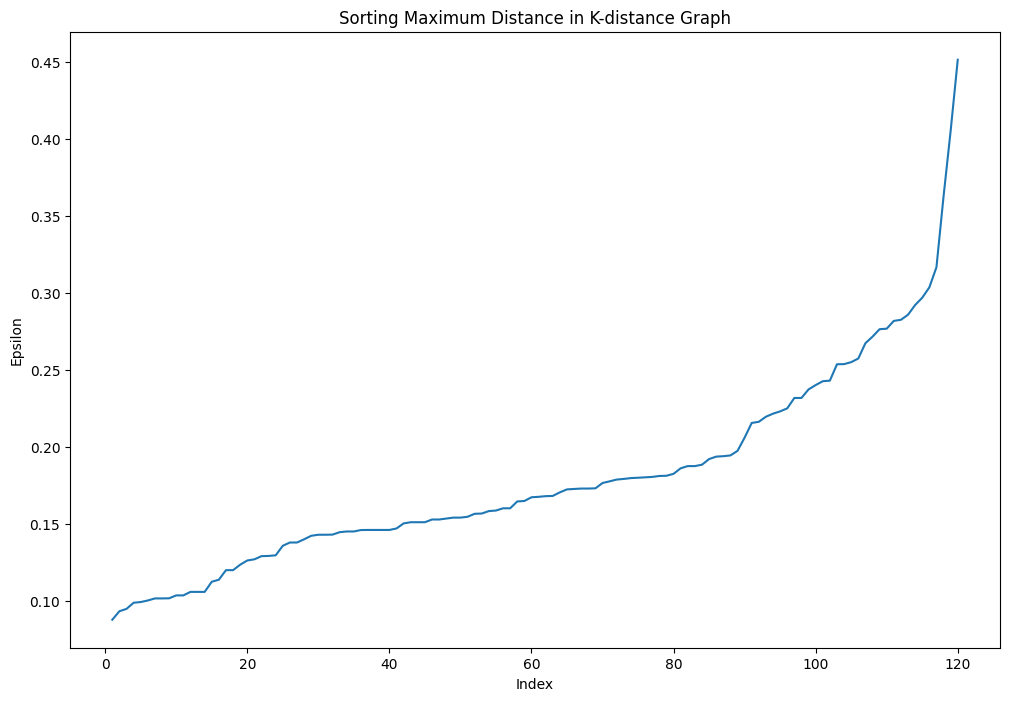

In [24]:
from sklearn.neighbors import NearestNeighbors


neighbors = 10
nbrs = NearestNeighbors(n_neighbors=neighbors).fit(X_train)

distances, indices = nbrs.kneighbors(X_train)

distance_desc = sorted(distances[:, neighbors-1], reverse=False)

plt.figure(figsize=(12, 8))
plt.plot(list(range(1,len(distance_desc )+1)), distance_desc)
plt.ylabel('Epsilon')
plt.xlabel('Index')
plt.title('Sorting Maximum Distance in K-distance Graph')

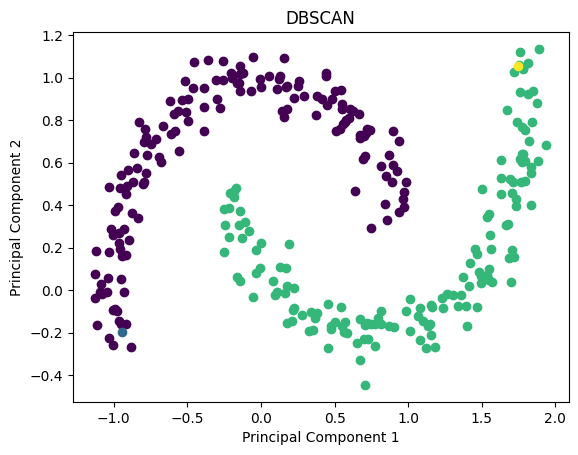

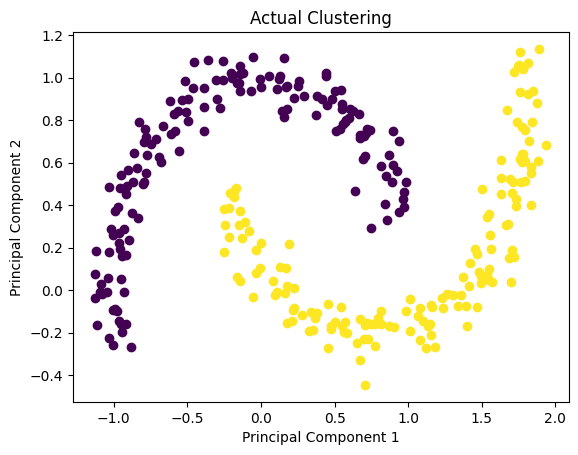

In [13]:
# Load the dataset
X, y = datasets.make_moons(n_samples=300, noise=0.08, shuffle=False)

# Cluster the data using DBSCAN
clf = DBSCAN(eps=0.17, min_samples=5)
y_pred = clf.predict(X)

# Project the data onto the 2 primary principal components
p = Plot()
p.plot_in_2d(X, y_pred, title="DBSCAN")
p.plot_in_2d(X, y, title="Actual Clustering")